In [1]:
import EnsembleXAI.Metrics as Metrics
import torchvision.transforms.functional as transform
import torch
from torchvision.transforms import Resize
import os
from PIL import Image
from torchvision.models import resnet50, ResNet50_Weights
import urllib.request
import json
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from captum.attr import IntegratedGradients
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from torchvision import transforms

In [2]:
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    imagenet_classes_dict = json.load(url)

In [3]:
dir_outside = "\\".join(os.getcwd().split(sep="\\")[:-1] + ['input'])
class_id = "n01491361"
path_masks = dir_outside + f'\\ImageNetS50\\train-semi-segmentation\\{class_id}\\'
kagglepath = f"/ILSVRC/Data/CLS-LOC/train/{class_id}/"
shark_filenames = os.listdir(path_masks)
resizer = Resize([224,224])
all_tensors = []
all_images = []
all_masks = []
for filename in shark_filenames:
    filename_jpeg = filename[:-3] + 'JPEG'
    #remove below comment to download the imagenet images. Kaggle user api key is required.
    #!kaggle competitions download -f {kagglepath}{filename} -p ./images -c imagenet-object-localization-challenge
    image = Image.open('.\\images\\'+filename_jpeg)
    image = resizer.forward(image)
    mask = Image.open(path_masks + filename)
    mask = resizer.forward(mask)
    mask = transform.to_tensor(mask)
    mask = (mask>0).float()
    x = transform.to_tensor(image)
    all_images.append(image)
    all_tensors.append(x)
    all_masks.append(mask)
tensor_images = torch.stack(all_tensors)
tensor_masks = torch.stack(all_masks)

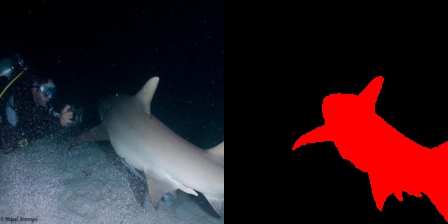

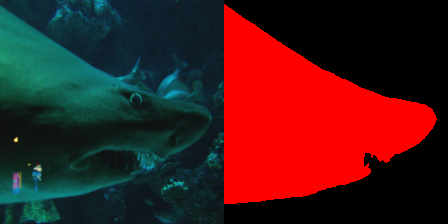

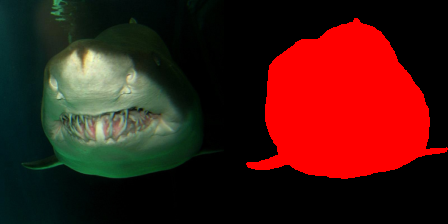

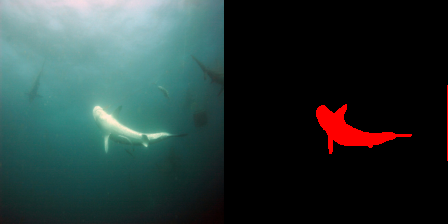

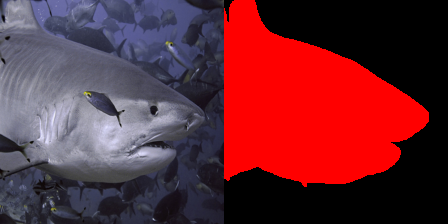

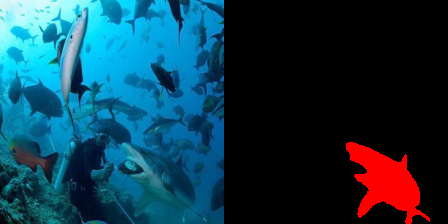

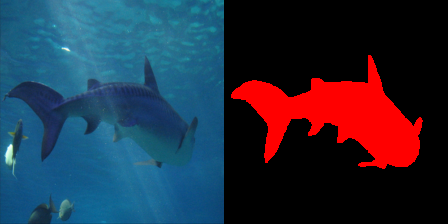

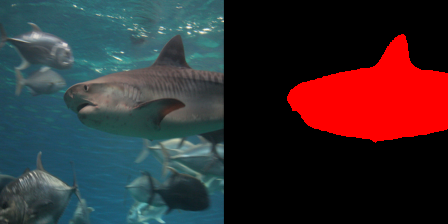

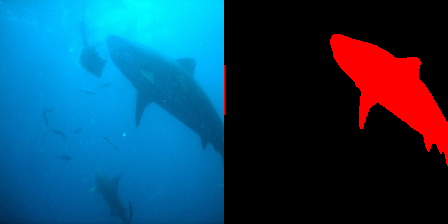

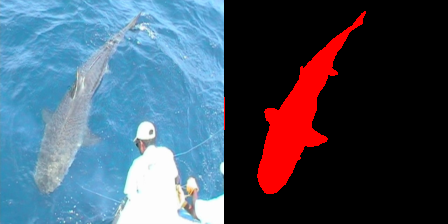

In [4]:
for tensor, mask in zip(all_tensors, all_masks):
    photo = torch.cat([tensor, mask], dim=2)
    display(transform.to_pil_image(photo))

In [5]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
outputs = model(tensor_images)
_, preds = torch.max(outputs, 1)
probs = torch.nn.functional.softmax(outputs, dim=1)
[imagenet_classes_dict[f'{i}'][1] for i in preds]

['hammerhead',
 'tiger_shark',
 'plastic_bag',
 'sea_lion',
 'tiger_shark',
 'hammerhead',
 'hammerhead',
 'tiger_shark',
 'hammerhead',
 'sturgeon']

In [7]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

img = Image.open('.\\images\\n01491361_868.JPEG')
transformed_img = transform(img)
input = transform_normalize(transformed_img)

In [8]:
pipeline = lambda images: torch.stack([transform_normalize(transform(image)) for image in images])

In [9]:
proper_data = pipeline(all_images)

In [10]:
outputs2 = model(proper_data)
_, preds2 = torch.max(outputs2, 1)
probs2 = torch.nn.functional.softmax(outputs2, dim=1)
[imagenet_classes_dict[str(i.item())][1] for i in preds2] # gar = Niszczukokształtne

['hammerhead',
 'tiger_shark',
 'tiger_shark',
 'great_white_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'tiger_shark',
 'gar']

In [11]:
single_pred = preds[2].unsqueeze(dim=0)
single_data = proper_data[2].unsqueeze(dim=0)
integrated_gradients = IntegratedGradients(model)
attributions_ig = integrated_gradients.attribute(single_data, target=single_pred, n_steps=200)

Basing on: https://captum.ai/tutorials/Resnet_TorchVision_Interpret

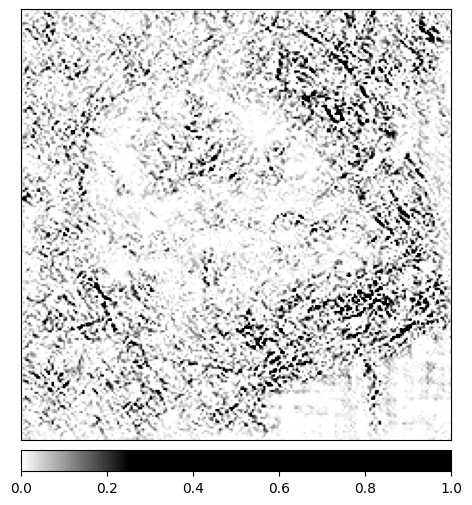

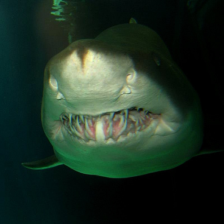

In [12]:
transformed_img = transform(all_images[2])
default_cmap = LinearSegmentedColormap.from_list('custom blue',
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             outlier_perc=1)
display(all_images[2])

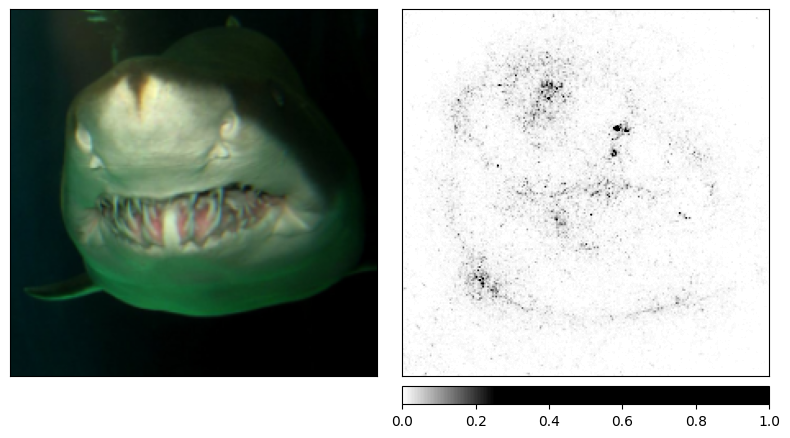

In [13]:
noise_tunnel = NoiseTunnel(integrated_gradients)

attributions_ig_nt = noise_tunnel.attribute(single_data, nt_samples=5, nt_type='smoothgrad_sq', target=single_pred)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)

In [14]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(single_data,
                                       strides = (3, 8, 8),
                                       target=single_pred,
                                       sliding_window_shapes=(3, 15, 15),
                                       baselines=0)

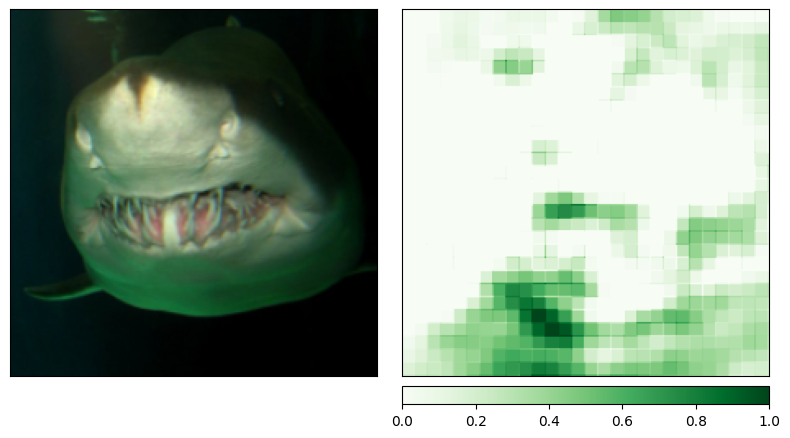

In [15]:
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

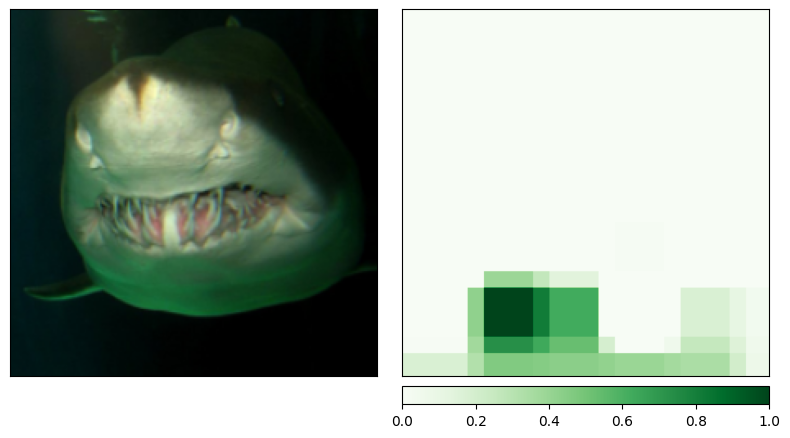

In [16]:
occlusion = Occlusion(model)

attributions_occ2 = occlusion.attribute(single_data,
                                       strides = (3, 40, 40),
                                       target=single_pred,
                                       sliding_window_shapes=(3,50, 50),
                                       baselines=0)
_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ2.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      show_colorbar=True,
                                      outlier_perc=2,
                                      )

In [17]:
occlusion = Occlusion(model)

attributions_occ3 = occlusion.attribute(tensor_images,
                                        strides = (3, 40, 40),
                                        target=preds,
                                        sliding_window_shapes=(3,50, 50),
                                        baselines=0)

In [26]:
Metrics.consistency(attributions_occ3)

0.0005522443098016083

In [27]:
Metrics.consistency(torch.cat([attributions_occ, attributions_occ2], dim=0))

0.0034804674796760082

In [65]:
predict = lambda x: torch.nn.Softmax(dim=0)(model(x))
Metrics.decision_impact_ratio(tensor_images, predict, attributions_occ3, 0.5, 0)

1.0

In [66]:
Metrics.confidence_impact_ratio(tensor_images, predict, attributions_occ3, 0.5, 0)

0.26301220059394836

In [36]:
Metrics.accordance_recall(tensor_images, tensor_masks[:, 0, :, :])

tensor([1.0000, 1.0000, 0.9959, 1.0000, 1.0000, 0.9611, 1.0000, 1.0000, 0.9684,
        1.0000])

In [37]:
Metrics.accordance_precision(tensor_images, tensor_masks[:, 0, :, :])

tensor([0.1962, 0.4796, 0.5010, 0.0339, 0.4849, 0.0638, 0.1856, 0.2076, 0.1354,
        0.1118])

In [38]:
Metrics.F1_score(tensor_images, tensor_masks[:, 0, :, :])

0.3576756417751312

In [35]:
Metrics.intersection_over_union(tensor_images, tensor_masks[:, 0, :, :])

0.3969152867794037

In [75]:
#attributions_occ2 = occlusion.attribute(single_data,
#                                        strides = (3, 40, 40),
#                                        target=single_pred,
#                                        sliding_window_shapes=(3,50, 50),
#                                        baselines=0)
def sample_xai(images):
    if images.shape[0] == 1:
        target = single_pred
    else:
        target = single_pred.repeat(images.shape[0])
    xai = occlusion.attribute(images,
                              strides = (3, 40, 40),
                              target=target,
                              sliding_window_shapes=(3,50, 50),
                              baselines=0)
    return xai
Metrics.stability(sample_xai, single_data.squeeze(dim=0), single_data.repeat(10,1,1,1))

0.0

In [74]:
single_pred.repeat(100)

tensor([728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728, 728,
        728, 728])